In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from PIL import Image
import pandas as pd
import subprocess
from sklearn.model_selection import train_test_split
#import keras_ocr
import src.tools as tools
import seaborn as sns
from tqdm import tqdm
import json
from datetime import date
import os
%matplotlib inline
%load_ext autoreload
%autoreload 2


In [7]:
!pip3 install gpsphoto
!pip3 install exifread
!pip3 install piexif

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [16]:
from GPSPhoto import gpsphoto
im_file = glob('/datadrive/stream_data/GrantPoole/*')
print(im_file[0])
im_data = gpsphoto.getRawData(im_file[0])

/datadrive/stream_data/GrantPoole/PICT0092.JPG


ValueError: invalid literal for int() with base 10: '2803360637/1538'

In [2]:
stations = ['ParkersBrook','BrownsBrook','GrantPoole' ]
stations = ['ParkersBrook']#['GrantPoole' ]

for station_name in stations:
    d = f'/datadrive/stream_data/{station_name}'

    #get the flowfiles

    cfs_to_cms = 0.028315847

    if station_name == 'GrantPoole':
        flowfile = glob(f'{d}/gage/*.csv')
        station_df = pd.read_csv(flowfile[0], header=2)
        station_df['DATETIME'] = pd.to_datetime(station_df['DATE'] + ' ' + station_df['TIME'])
        station_df['Discharge, cfs'] = station_df['Discharge (m3/sec)'] / cfs_to_cms
    else:
        flowfile = glob(f'{d}/gage/*.xlsx')
        station_df = pd.read_excel(flowfile[0])
        station_df.rename(columns={'Date Time, GMT-05':'DATETIME'},inplace=True)
        #add Discharge at m3/sec
        station_df['Discharge (m3/sec)'] = station_df['Discharge, cfs'] * cfs_to_cms
        
    station_df['DISCHARGE'] = station_df['Discharge (m3/sec)']
    station_df['ZSCORE'] = z_score(station_df['Discharge (m3/sec)'])

    #take standard deviation as a class
    hi = np.array((station_df['ZSCORE']>=1).astype('int')*2)
    lo = np.array((station_df['ZSCORE']<=0).astype('int'))
    classes = hi+lo #high:2, low:1, mid:0
    station_df['CATEGORY'] = classes
    #get the image files time-stamp so we can link and create labels
    ext = 'JPG'
    imgs = sorted(glob(f'{d}/*.{ext}'))
    ext = 'jpg'
    imgs.extend(sorted(glob(f'{d}/*.{ext}')))

    img_df = pd.DataFrame([{'FILENAME':im,\
               'DATETIME_RAW':pd.Timestamp(tools.get_datetime(im))} for im in tqdm(imgs)])

    img_df['DATETIME_RAW'] = img_df.DATETIME_RAW.astype('datetime64')#now join img_df to df
    img_df['DATETIME'] = img_df['DATETIME_RAW'].round('30min')
    #then we round after

    training_data = img_df.merge(station_df, on='DATETIME')[['FILENAME',\
                                                             'DATETIME',\
                                                             'DISCHARGE',\
                                                             'ZSCORE',\
                                                             'CATEGORY']]
    #write this data to csv
    training_data['FILENAME_RAW'] = [i.split('/')[-1] for i in training_data['FILENAME']]
    outfile = f'/datadrive/stream_data/training/{station_name}/{station_name}_table.csv'
#    training_data.to_csv(outfile, header=True, index=True, index_label='INDEX')

100%|██████████| 5797/5797 [32:20<00:00,  2.99it/s]


In [110]:
hi = 2*np.array((station_df['ZSCORE']>1.5)).astype('int')
mid = np.array((station_df['ZSCORE']>=1) & (station_df['ZSCORE']<=1.5)).astype('int')
lo = np.array((station_df['ZSCORE']<0)).astype('int')
classes = lo+mid+hi

(array([14288.,     0.,     0.,     0.,     0., 31505.,     0.,     0.,
            0.,  2050.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

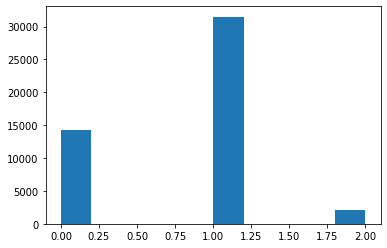

In [111]:
plt.hist(classes)

In [50]:
img_df.head()

,FILENAME,DATETIME_RAW,DATETIME
0,/datadrive/stream_data/ParkersBrook/20180613_1...,2018-06-13 12:30:14,2018-06-13 12:30:00
1,/datadrive/stream_data/ParkersBrook/20180613_1...,2018-06-13 13:30:14,2018-06-13 13:30:00
2,/datadrive/stream_data/ParkersBrook/20180613_1...,2018-06-13 14:30:14,2018-06-13 14:30:00
3,/datadrive/stream_data/ParkersBrook/20180613_1...,2018-06-13 15:30:15,2018-06-13 15:30:00
4,/datadrive/stream_data/ParkersBrook/20180613_1...,2018-06-13 16:30:14,2018-06-13 16:30:00


In [84]:
training_data.head()

,FILENAME,DATETIME,DISCHARGE,ZSCORE,CATEGORY,FILENAME_RAW
0,/datadrive/stream_data/ParkersBrook/20180613_1...,2018-06-13 12:30:00,0.094827,-0.894536,0,20180613_1230_ParkersBrook.JPG
1,/datadrive/stream_data/ParkersBrook/20180613_1...,2018-06-13 13:30:00,0.112465,-0.834123,0,20180613_1330_ParkersBrook.JPG
2,/datadrive/stream_data/ParkersBrook/20180613_1...,2018-06-13 14:30:00,0.106370,-0.855000,0,20180613_1430_ParkersBrook.JPG
3,/datadrive/stream_data/ParkersBrook/20180613_1...,2018-06-13 15:30:00,0.106370,-0.855000,0,20180613_1530_ParkersBrook.JPG
4,/datadrive/stream_data/ParkersBrook/20180613_1...,2018-06-13 16:30:00,0.106370,-0.855000,0,20180613_1630_ParkersBrook.JPG


(array([4.559e+03, 1.061e+03, 1.000e+02, 4.000e+01, 1.300e+01, 1.000e+01,
        5.000e+00, 2.000e+00, 3.000e+00, 2.000e+00]),
 array([-0.96829867,  0.47299634,  1.91429136,  3.35558638,  4.79688139,
         6.23817641,  7.67947142,  9.12076644, 10.56206146, 12.00335647,
        13.44465149]),
 <BarContainer object of 10 artists>)

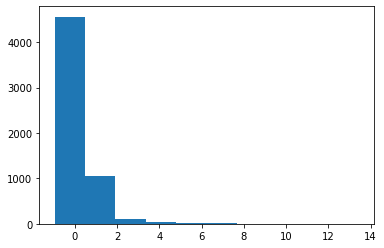

In [46]:
plt.hist(training_data['ZSCORE'])

In [44]:
idx = np.arange(len(training_data))
np.random.shuffle(idx)
batch = pd.DataFrame([training_data.iloc[i] for i in idx[:25]])
batch

,FILENAME,DATETIME,DISCHARGE,ZSCORE,CATEGORY,FILENAME_RAW
3495,/datadrive/stream_data/ParkersBrook/20190330_1...,2019-03-30 18:00:00,0.524250,0.576292,0,20190330_1800_ParkersBrook.jpg
147,/datadrive/stream_data/ParkersBrook/20180623_1...,2018-06-23 19:00:00,0.089373,-0.913219,0,20180623_1900_ParkersBrook.JPG
1854,/datadrive/stream_data/ParkersBrook/20181104_1...,2018-11-04 11:00:00,0.789733,1.485603,2,20181104_1100_ParkersBrook.JPG
2795,/datadrive/stream_data/ParkersBrook/20190131_1...,2019-01-31 12:00:00,1.282846,3.174579,2,20190131_1100_ParkersBrook.jpg
173,/datadrive/stream_data/ParkersBrook/20180625_1...,2018-06-25 17:00:00,0.242368,-0.389191,0,20180625_1700_ParkersBrook.JPG
4373,/datadrive/stream_data/ParkersBrook/20190606_0...,2019-06-06 06:00:00,0.285324,-0.242061,0,20190606_0600_ParkersBrook.jpg
4137,/datadrive/stream_data/ParkersBrook/20190518_1...,2019-05-18 17:00:00,0.427918,0.246342,0,20190518_1700_ParkersBrook.jpg
2801,/datadrive/stream_data/ParkersBrook/20190131_1...,2019-01-31 18:00:00,0.320363,-0.122046,0,20190131_1700_ParkersBrook.jpg
5039,/datadrive/stream_data/ParkersBrook/20190801_1...,2019-08-01 10:00:00,0.156215,-0.684275,0,20190801_1000_ParkersBrook.jpg
5561,/datadrive/stream_data/ParkersBrook/20190928_1...,2019-09-28 10:00:00,0.165295,-0.653174,0,20190928_1000_ParkersBrook.jpg


Text(0.5, 1.0, '2018-06-19 18:00:00')

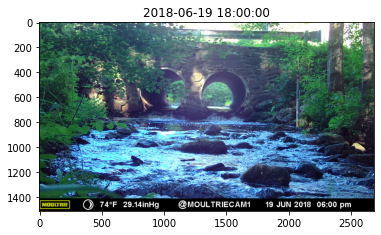

In [3]:
i = 90
plt.imshow(Image.open(imgs[i]))
plt.title(tools.get_datetime(imgs[i]))
#seems like the time stamps line up
#now re-explore the gauge station value

In [4]:
station_df.columns

Index(['DATETIME', 'Stage, ft', 'Discharge, cfs', 'Discharge (m3/sec)',
       'DISCHARGE', 'ZSCORE', 'CATEGORY'],
      dtype='object')

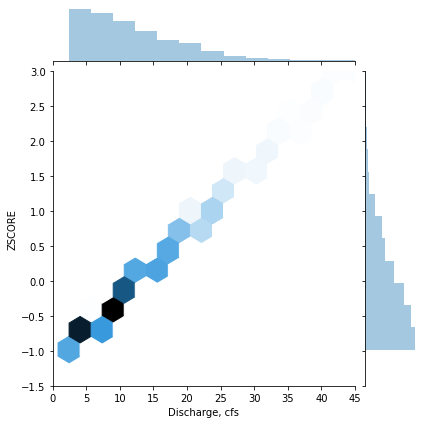

In [19]:
# Visualize to see the one-to-one relationship with the raw Discharge, cfs to Zscore
import seaborn as sns
sns.jointplot(station_df['Discharge, cfs'], station_df['ZSCORE'], kind='hex',\
              xlim=(0,45), ylim=(-1.5,3))

In [3]:
stations = ['ParkersBrook','BrownsBrook','GrantPoole']
for station in stations:
    wd = f'/datadrive/stream_data/training/{station}'
    #read filenames
    df = pd.read_csv(f'{wd}/{station}_table.csv')
    split_ratio = 0.3
    seed = 1337 
    tables = create_data_splits(df,split_ratio=split_ratio,seed=seed) 
    #divide the data into training validation test
    bins = ['train', 'val', 'test']
    for b in bins:
        path = f'{wd}/{b}'
        if not os.path.exists(path):
            os.mkdir(path)
        NEW_R,NEW_C = 640,480
        new_shape = (NEW_R, NEW_C)
        filelist = []
        for ref_im,name in tqdm(zip(tables[b]['FILENAME'], tables[b]['FILENAME_RAW'])):
            new_filename = f'{path}/{name.lower()}'
            #resize and save image in int format
            #write these files but only after path has been assigned 
            rz_im = image_resize(Image.open(ref_im), shape=new_shape).save(new_filename)
            filelist.append(new_filename)
        tables[b]['FILENAME'] = filelist
        outtable = tables[b].copy()[['INDEX','DATETIME','DISCHARGE','ZSCORE','CATEGORY']]
        outtable['FILENAME'] = filelist
        outtable_name = f'{wd}/{b}_table.csv'
        outtable.to_csv(outtable_name, header=True, index=False)

4056it [07:08,  9.47it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
869it [01:32,  9.44it/s]
870it [01:31,  9.47it/s]
2204it [03:55,  9.35it/s]
472it [00:50,  9.33it/s]
473it [00:50,  9.36it/s]
559it [01:05,  8.49it/s]
120it [00:14,  8.44it/s]
120it [00:14,  8.50it/s]


In [91]:


########################BREAK#######################



In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [ ]:
###alternative method to make tfrecords
y_var = 'Discharge (m3/sec)'
x_var = 'image'
y = training_data[y_var].values.astype('float32') 

#reshape
xtrain = [Image.open(i) for i in tqdm(imgs)]
r,c = xtrain[0].size

#resize the image...
scale = 0.2
xtrain = np.array([np.array(x.resize((int(r*scale), int(c*scale)))) for x in tqdm(xtrain)])
ytrain = y
train_dataset = tf.data.Dataset.from_tensor_slices((xtrain,ytrain))

#write to tfrecord.gz
datafile = f'{station_name}-training.tfrecord.gz'
out_location = f'/datadrive/stream_data/training/{datafile}'
tf.data.experimental.save(train_dataset, out_location, compression='GZIP')

e_spec = {'x_data': {'shape':tuple(train_dataset.element_spec[0].shape),\
                     'dtype':train_dataset.element_spec[0].dtype.name,\
                     'name':'image'},\
         'y_data': {'shape':tuple(train_dataset.element_spec[1].shape),\
                     'dtype':train_dataset.element_spec[1].dtype.name,\
                     'name':'label'}}
json_out = {
"name": station_name,
"creation_dated": date.today().strftime("%Y/%m/%d"),
"x_var": x_var,
"y_var": y_var,
"count": ytrain.shape[0],
"element_spec": e_spec 
}
#save the metadata too
metadata_file = f'{station_name}-training_metadata.json'
out_location = f'/datadrive/stream_data/training/{metadata_file}'
with open(out_location,'w') as metadata:
    json.dump(json_out, metadata)


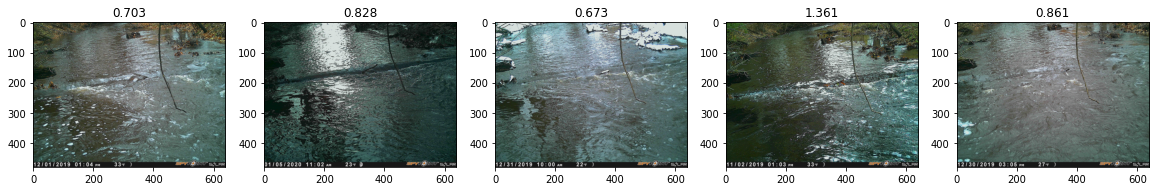

In [54]:
SHUFFLE_BUFFER_SIZE = 100 
BATCH_SIZE = 8 
train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

f, ax = plt.subplots(1,5, figsize=(20,4))
for i in range(5):
    ax[i].imshow(X_train[i])
    ax[i].set_title(y_train[i])

In [80]:
from tensorflow.keras.metrics import Metric
from tensorflow.python.keras.utils import losses_utils

class RSquare(Metric):
    """Computes coefficient of determination`y_true` and `y_pred`."""
    def __init__(self, name='R2', dtype=None):
        super(RSquare, self).__init__(name, dtype=dtype)
        
    def R_squared(self,y, y_pred):
        '''
        R_squared computes the coefficient of determination.
        It is a measure of how well the observed outcomes are replicated by the model.
        '''
        residual = tf.reduce_sum(tf.square(tf.subtract(y, y_pred)))
        total = tf.reduce_sum(tf.square(tf.subtract(y, tf.reduce_mean(y))))
        r2 = tf.subtract(1.0, tf.divide(residual, total))
        return r2

    def update_state(self, y_true, y_pred):
        """Accumulates root mean squared error statistics.
        Args:
          y_true: The ground truth values.
          y_pred: The predicted values.
          sample_weight: Optional weighting of each example. Defaults to 1. Can be a
            `Tensor` whose rank is either 0, or the same rank as `y_true`, and must
            be broadcastable to `y_true`.
        Returns:
          Update op.
        """
        y_true = tf.expand_dims(tf.cast(y_true, self._dtype), axis=1)
        y_pred = tf.cast(y_pred, self._dtype)
        #y_pred, y_true = losses_utils.squeeze_or_expand_dimensions(
        #    y_pred, y_true)
        r2 = self.R_squared(y, y_pred)
        return super(RSquare, self).update_state(r2)

    def result(self):
        return tf.subtract(1.0, tf.math.divide_no_nan(self.residual, self.total))


In [82]:
EPOCHS = 2 

for epoch in tqdm(range(EPOCHS)):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()
    
    for images, labels in train_dataset:
        train_step(images, labels)
        
    for test_images, test_labels in test_dataset:
        test_step(test_images, test_labels)
    template = 'Epoch {}, Loss: {:.2f}, Accuracy: {:.2f},\
                Test Loss: {:.2f}, Test Accuracy: {:.2f}'
    #template = 'Epoch {}, Loss: {}, Test Loss: {}'
    print(f'')
    print(template.format(epoch + 1,
                        train_loss.result(),\
                        test_loss.result(),\
                        train_accuracy.result(),\
                        test_accuracy.result()))

  0%|          | 0/2 [00:02<?, ?it/s]

(8, 1)
(8, 1)


NotImplementedError: in user code:

    <ipython-input-78-b29109ee5a20>:44 train_step  *
        train_accuracy(labels, predictions)
    <ipython-input-80-4bbc846d0e0c>:38 update_state  *
        return super(RSquare, self).update_state(r2)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/metrics.py:267 update_state  **
        raise NotImplementedError('Must be implemented in subclasses.')

    NotImplementedError: Must be implemented in subclasses.


In [15]:
tests_predictions = model.predict(X_test)

In [17]:
tests_predictions.shape

(160, 1)

In [165]:
#for AI data extraction
#let's batch the predictions
'''
n = len(imgs)
a = 0
b = 6 
image_batch = imgs[a:b]
images = [keras_ocr.tools.read(img_file) for img_file in image_batch]
pipeline = keras_ocr.pipeline.Pipeline()
prediction_groups = pipeline.recognize(images)
out = label_prediction_groups(prediction_groups, label_group)
out
#test
pipeline = keras_ocr.pipeline.Pipeline()
images = [keras_ocr.tools.read(img_file) for img_file in imgs[:2]]
prediction_groups = pipeline.recognize(images)
fig, axs = plt.subplots(nrows=len(images), figsize=(20, 20))
for ax, image, predictions in zip(axs, images, prediction_groups):
    keras_ocr.tools.drawAnnotations(image=image, predictions=predictions, ax=ax)
'''

'\nn = len(imgs)\na = 0\nb = 6 \nimage_batch = imgs[a:b]\nimages = [keras_ocr.tools.read(img_file) for img_file in image_batch]\npipeline = keras_ocr.pipeline.Pipeline()\nprediction_groups = pipeline.recognize(images)\nout = label_prediction_groups(prediction_groups, label_group)\nout\n#test\npipeline = keras_ocr.pipeline.Pipeline()\nimages = [keras_ocr.tools.read(img_file) for img_file in imgs[:2]]\nprediction_groups = pipeline.recognize(images)\nfig, axs = plt.subplots(nrows=len(images), figsize=(20, 20))\nfor ax, image, predictions in zip(axs, images, prediction_groups):\n    keras_ocr.tools.drawAnnotations(image=image, predictions=predictions, ax=ax)\n'